## Importing Packages

In [2]:
import os
import sys
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
import itertools
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, \
StackingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report
import warnings
import xgboost
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
#from wordcloud import WordCloud
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical # for target labels
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2, l1

In [2]:
df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


# Data Undersatding

In [3]:
df['category'].value_counts()

Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: category, dtype: int64

In [4]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [5]:
# Creating 'target' Column for Classification
df['target'] = np.where(df['label'] == 'CG', 1, 0)

In [6]:
df

,category,rating,label,text_,target
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",1
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,1
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",1
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,1
...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...,0
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...,1
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ...",0
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...,1


### Destribution of categories by rating

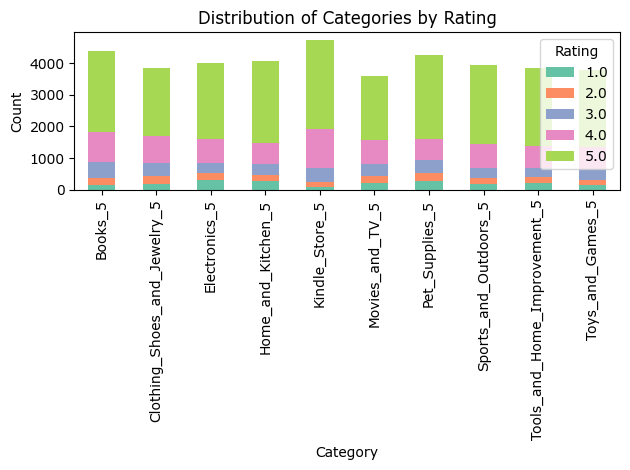

In [7]:
# Bar Chart for Distribution of Categories by Rating
sns.set_palette("Set2")

df_grouped = df.groupby(['category', 'rating']).size().unstack(fill_value=0)
ax = df_grouped.plot(kind='bar', stacked=True)

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories by Rating')
plt.xticks(rotation=90)
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

- Some categories, such as "Books" and "Kindle Store," have a more substantial proportion of highly positive reviews (5.0), while others like "Electronics" and "Pet Supplies" have a relatively higher number of reviews with lower ratings (1.0, 2.0, and 3.0).

<Figure size 1200x600 with 0 Axes>

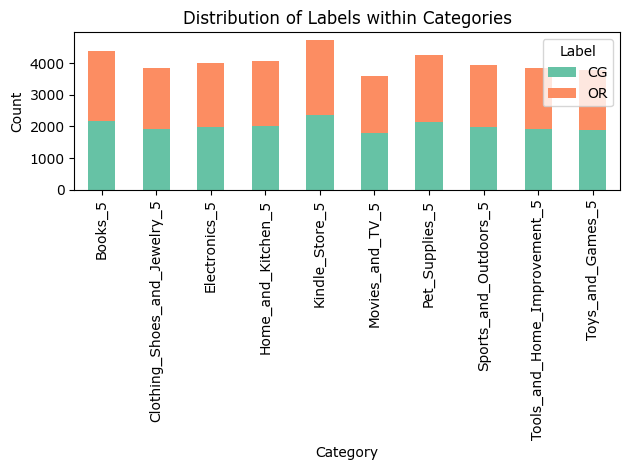

In [8]:
#Bar Chart for Distribution of Labels within Categories
plt.figure(figsize=(12, 6))
label_category_counts = df.groupby(['category', 'label']).size().unstack(fill_value=0)
label_category_counts.plot(kind='bar', stacked=True)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Labels within Categories')
plt.xticks(rotation=90)
plt.legend(title='Label')
plt.tight_layout()

plt.show()

-  The table shows an equal distribution of the "CG" and "OR" labels within each category. 

In [9]:
# Calculating Word Count for Each Text Entry
df['word_count'] = df['text_'].apply(lambda x: len(x.split()))

In [10]:
# Calculating Average Word Count by Label
label_word_counts = df.groupby('label')['word_count'].mean().sort_values(ascending=False)

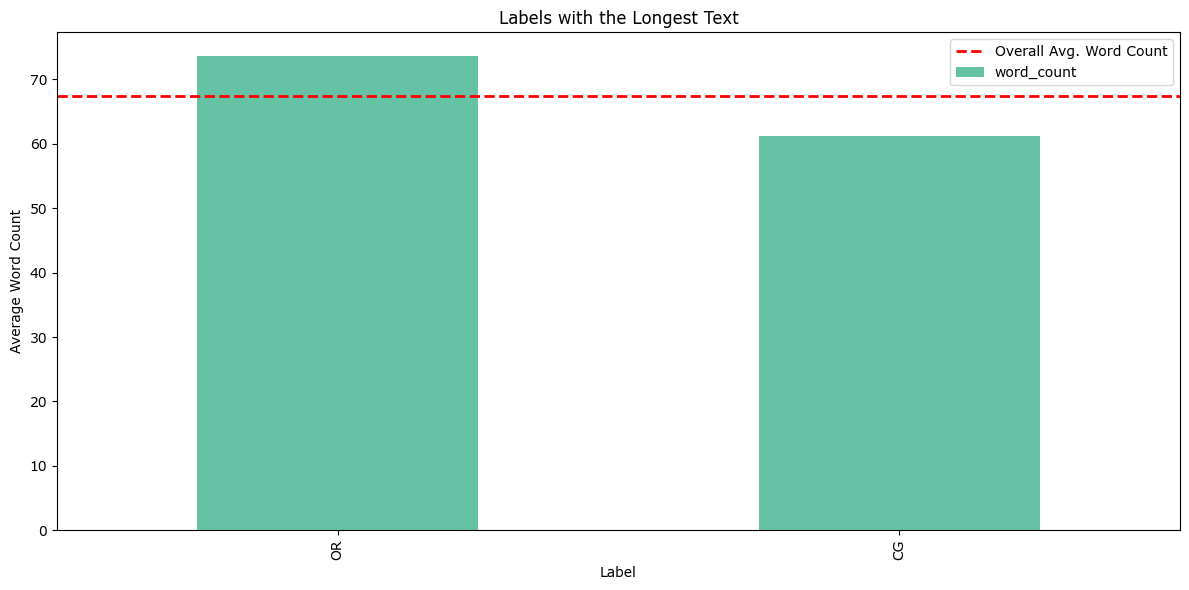

In [11]:
plt.figure(figsize=(12, 6))
label_word_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Average Word Count')
plt.title('Labels with the Longest Text')
plt.xticks(rotation=90)
plt.axhline(df['word_count'].mean(), color='red', linestyle='dashed', linewidth=2, label='Overall Avg. Word Count')
plt.legend()
plt.tight_layout()

plt.show()

- On average, reviews with the "OR" label have a higher word count compared to reviews labeled as "CG." The mean word count for "OR" reviews is approximately 73.64 words, while the mean word count for "CG" reviews is lower at around 61.29 words.

In [12]:
label_rating_counts = df.groupby(['label', 'rating']).size().unstack(fill_value=0)
label_rating_counts

rating,1.0,2.0,3.0,4.0,5.0
label,,,,,
CG,1063,962,1952,3920,12319
OR,1092,1005,1834,4045,12240


<Figure size 1200x600 with 0 Axes>

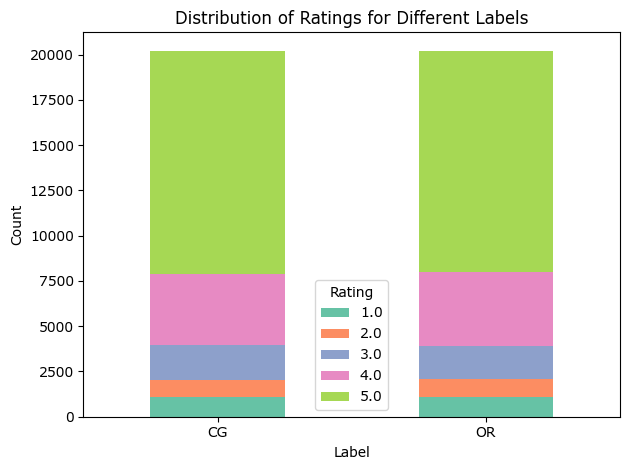

In [13]:
# Distribution of Ratings for Different Labels
plt.figure(figsize=(12, 6))
label_rating_counts.plot(kind='bar', stacked=True)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Ratings for Different Labels')
plt.xticks(rotation=0)  
plt.legend(title='Rating', labels=label_rating_counts.columns)
plt.tight_layout()
plt.show()

- Both "CG" and "OR" labels exhibit a relatively balanced distribution of ratings. While both labels have a similar distribution of ratings, the "CG" label appears to have slightly fewer reviews with 4.0 and 5.0 ratings compared to the "OR" label. Across both labels, positive ratings (4.0 and 5.0) significantly outnumber negative ratings (1.0 and 2.0).

In [14]:
label_category_counts = df.groupby(['label', 'category']).size().unstack(fill_value=0)
label_category_counts

category,Books_5,Clothing_Shoes_and_Jewelry_5,Electronics_5,Home_and_Kitchen_5,Kindle_Store_5,Movies_and_TV_5,Pet_Supplies_5,Sports_and_Outdoors_5,Tools_and_Home_Improvement_5,Toys_and_Games_5
label,,,,,,,,,,
CG,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897
OR,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897


<Figure size 1200x600 with 0 Axes>

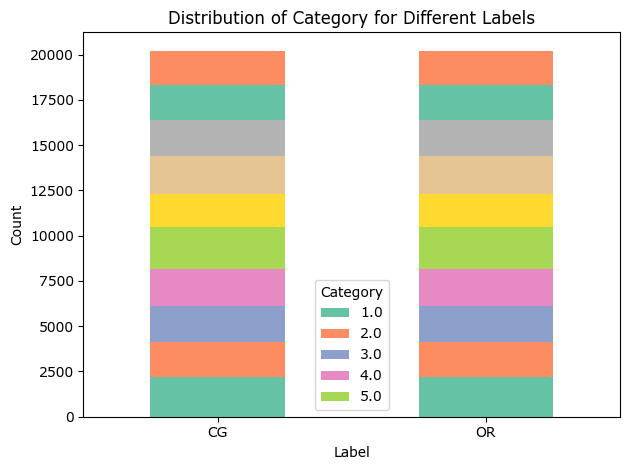

In [15]:
# Label-Category Distribution
plt.figure(figsize=(12, 6))
label_category_counts.plot(kind='bar', stacked=True)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Category for Different Labels')
plt.xticks(rotation=0)  
plt.legend(title='Category', labels=label_rating_counts.columns)
plt.tight_layout()
plt.show()

-  The table reveals a consistent distribution of "CG" and "OR" labels across various product categories, with no apparent variation in label assignment within these categories.

### Word Cloud for Label column

In [16]:
# Filtering Data for 'CG' and 'OR' Labels
df_cg = df[df['label'] == 'CG']  
df_or = df[df['label'] == 'OR']

In [17]:
# Word Cloud for 'OR' Label Using a Custom Mask
face_mask = np.array(Image.open('/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/face_picture.jpeg'))
text_corpus = " ".join(df_or['text_'])

wordcloud = WordCloud(
    width=600,
    height=600,
    background_color='white',
    mask=face_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "OR" Label ', fontsize=20)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/face_picture.jpeg'

In [ ]:
# Word Cloud for 'CG' Label Using a Custom Mask
robot_mask = np.array(Image.open('/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/SIlhouette.png'))
text_corpus_2 = " ".join(df_cg['text_'])

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    mask=robot_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus_2)


plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "CG" Label ', fontsize=20)
plt.show()

# Data Preprocessing

## Text Preprocessing: Tokenization

In [18]:
# Tokenizing the text data in the 'text_' column of df
def tokenizer(x):
    
    corpus = [word_tokenize(doc) for doc in x]

# Getting common stop words in english that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    corpus_no_stopwords = []
    for words in corpus:
        docs = [x.lower() for x in words if ((x.isalpha()) & (x not in stop_words))]
        corpus_no_stopwords.append(docs)
    return corpus_no_stopwords

## Lemmantizer

In [19]:
# Defining new function 'lemmatizer'. This function takes two arguments: corpus(list of sentences or text data that we want to lemmatize), and as_string 
def lemmatizer(corpus, as_string=True):
    lem = WordNetLemmatizer()
# Defining an inner function 'pos_tagger'    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
    lemmatized_corpus = []
    for sentence in corpus:
        pos_tags = pos_tag(sentence)
        lemmatized_sentence = []
        for word, tag in pos_tags:
            pos = pos_tagger(tag)
            if pos is not None:
                lemmatized_word = lem.lemmatize(word, pos)
            else:
                lemmatized_word = lem.lemmatize(word)
            lemmatized_sentence.append(lemmatized_word)
        lemmatized_corpus.append(lemmatized_sentence)
    if as_string:
        lemmatized_corpus  = [' '.join(x) for x in lemmatized_corpus]
    return lemmatized_corpus
# After processing all words in the sentence, the lemmatized_sentence is added to the lemmatized_corpus
        

In [20]:
# Tokenizing a text corpus
#corpus_tokenized = tokenizer(df['text_'])

In [21]:
# Lemmatizing a text corpus
#lemmatized_corpus = lemmatizer(corpus_tokenized)

## Pre vectorizing

In [22]:
# # Adding Preprocessed Text Column to DataFrame
# joined_lemm_corpus = [' '.join(x) for x in lemmatized_corpus]
# df['text_preproccesed'] = pd.Series(data=lemmatized_corpus)

In [23]:
# # Creating Document-Term Matrix Using CountVectorizer
# vec = CountVectorizer(min_df = 0.05, max_df = 0.95)
# X = vec.fit_transform(lemmatized_corpus)
# countvec_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

In [24]:
# # Creating TF-IDF Matrix Using TfidfVectorizer
# tfidf = TfidfVectorizer(min_df = 0.05, max_df = 0.95)
# Y = tfidf.fit_transform(lemmatized_corpus)
# tfidf_df = pd.DataFrame(Y.toarray(), columns=tfidf.get_feature_names_out())

In [25]:
#tfidf_df

### Splitting Data into Training and Testing Sets

In [26]:
X_train, X_test, y_train,y_test = train_test_split(df['text_'],df['target'], test_size=0.3,random_state=42)

In [27]:
# Preprocessing Text Data in Training and Testing Sets
X_train_preprocessed = lemmatizer(tokenizer(X_train))
X_test_preprocessed = lemmatizer(tokenizer(X_test))

### Random Forest and Logistic Regression with the Count Vectorizer

In [28]:
X_train_preprocessed

['this great love story i think book much i think u fell love book it awesome story',
 'nicely do i would appreciate entry show density renter insulae',
 'i love easy put chain stay wash',
 'who do not like henry winkler it be just one on my favorite',
 'best glove i buy far perfect almost trade give protection knuckle durable',
 'i use pinterest past find great way keep track go around i also use trolley book club social medium platform keep track event happen personal blog learn event lot people i connect i receive book exchange honest opinion i highly recommend anyone enjoy read life read book one sit immediately fell love i excite read read it great read i love author make',
 'absolutely love kitchen towel i redecorate kitchen owl theme look perfect',
 'i instal striker master instruction include these work well extra power great i use extra power keep light i use house light the light output watt i several light house single light i instal several light room',
 'nice piece short p

In [29]:
# Train and Evaluate Random Forest Model with CountVectorizer
steps = [('countvec',CountVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200,random_state=42))]
pipe_cv_rf = Pipeline(steps)
pipe_cv_rf.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Random Forest Model with CountVectorizer
crossval_rf_cv = np.mean(cross_val_score(pipe_cv_rf, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_rf_cv

0.7627021346850904

In [30]:
# Train and Evaluate Logistic Regression Model with CountVectorizer
steps[1] = ('logreg',LogisticRegression(random_state=42))
pipe_cv_lr = Pipeline(steps)
pipe_cv_lr.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Logistic Regression Model with CountVectorizer
crossval_lr_cv = np.mean(cross_val_score(pipe_cv_lr, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_lr_cv

0.7266269054338063

### Random Forest and Logistic Regression with the Tfidf Vectorizer

In [31]:
# Train and Evaluate Random Forest Model with TfidfVectorizer
steps = [('tfidfvec',TfidfVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200,random_state=42))]
pipe_idf_rf = Pipeline(steps)
pipe_idf_rf.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Random Forest Model with TfidfVectorizer
crossval_rf_idf = np.mean(cross_val_score(pipe_idf_rf, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_rf_idf

0.7631969029932032

In [32]:
# Train and Evaluate Logistic Regression Model with TfidfVectorizer
steps[1] = ('logreg',LogisticRegression(random_state=42))
pipe_idf_lr = Pipeline(steps)
pipe_idf_lr.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Logistic Regression Model with TfidfVectorizer
crossval_lr_idf = np.mean(cross_val_score(pipe_idf_lr, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_lr_idf

0.7267683043675561

- We run two models with both types of vectorizers, and based on our scores, we decided to stick with the Count Vectorizer.

In [33]:
vectorizer = CountVectorizer(min_df=0.05,max_df=0.95)

X_train_vec = vectorizer.fit_transform(X_train_preprocessed)
X_test_vec = vectorizer.transform(X_test_preprocessed)

### Hyperparameter Grids

In [34]:
# Defining Hyperparameter Grids for Random Forest and Logistic Regression Models
param_rf = {'n_estimators':[100,150,200],
                       'max_depth':[2,3,4,5],
                       'min_samples_leaf':[1,2,3]
                      }

param_lr = {'penalty':['l1', 'l2', 'elasticnet', None],
                 'C':[0.001,0.01,0.1,1,10,100],
                 'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
                }

### Hyperparameter Tuning with GridSearchCV

In [35]:
gs_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,random_state=42), param_grid=param_rf,scoring='accuracy',cv=5,error_score=0)
gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42,max_iter=10000), param_grid=param_lr,scoring='accuracy',cv=5,error_score=0)
gs_rf.fit(X_train_vec,y_train)
gs_lr.fit(X_train_vec,y_train)

GridSearchCV(cv=5, error_score=0,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [36]:
# Best Hyperparameters for Random Forest Model
best_random_forest = gs_rf.best_estimator_

# Best Cross-Validation Score for Random Forest Model
gs_rf.best_score_

0.7006221915118195

In [37]:
# Best Hyperparameters for Logistic Regression Model
best_logistic_regression = gs_lr.best_estimator_

# Best Cross-Validation Score for Logistic Regression Model
gs_lr.best_score_

0.7277222181649535

### AdaBoost Classifier with CountVectorizer

In [38]:
ada_booster = AdaBoostClassifier(random_state=42).fit(X_train_vec,y_train)

crossval_ada_booster = np.mean(cross_val_score(ada_booster, X_train_vec,y_train,scoring='accuracy',cv=5))
crossval_ada_booster

0.7256379056254343

### GradientBoosting Classifier 

In [39]:
gradient_bc = GradientBoostingClassifier(random_state=42).fit(X_train_vec,y_train)

crossval_gradient_booster = np.mean(cross_val_score(gradient_bc, X_train_vec,y_train,scoring='accuracy',cv=5))
crossval_gradient_booster

0.7378985969964976

### XGBClassifier with CountVectorizer

In [40]:
xg_boost_classifier = xgboost.XGBClassifier(random_state=42, objective='binary:logistic').fit(X_train_vec,y_train)

crossval_xg_booster = np.mean(cross_val_score(xg_boost_classifier, X_train_vec,y_train,scoring='accuracy',cv=5))
crossval_xg_booster

0.7701926515998435

### Hyperparameter Grids for Boosting Algorithms

In [41]:
param_grid_ada = {'n_estimators':[50,100,150,200],
                  'learning_rate':[0.01,0.1,0.2,0.5,1]
                 }

param_grid_gradient = {'n_estimators':[50,100,150,200],
                       'learning_rate':[0.01,0.1,0.2,0.5,1],
                       'max_depth':[1,2,3,4]
                      }

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2]
}

In [42]:
gs_ada = GridSearchCV(estimator=ada_booster, param_grid=param_grid_ada,scoring='accuracy',cv=5,error_score=0)
gs_gradient = GridSearchCV(estimator=gradient_bc, param_grid=param_grid_gradient,scoring='accuracy',cv=5,error_score=0)
gs_xgb = GridSearchCV(estimator=xg_boost_classifier, param_grid=param_grid_xgb,scoring='accuracy',cv=5,error_score=0)

In [43]:
# Fitting the AdaBoost GridSearchCV
gs_ada.fit(X_train_vec,y_train)

GridSearchCV(cv=5, error_score=0, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [44]:
# Fitting the GradientBoostingClassifier GridSearchCV
gs_gradient.fit(X_train_vec,y_train)

GridSearchCV(cv=5, error_score=0,
             estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [45]:
# Fitting the XGBClassifier GridSearchCV
gs_xgb.fit(X_train_vec,y_train)

GridSearchCV(cv=5, error_score=0,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learn...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

### Best Hyperparameters and Cross-Validation Scores

In [46]:
# Best Hyperparameters for AdaBoost Classifier
gs_ada.best_params_

{'learning_rate': 0.5, 'n_estimators': 200}

In [47]:
# Best Cross-Validation Score for AdaBoost Classifier
gs_ada.best_score_

0.7383930532070212

In [48]:
best_ada_boost = gs_ada.best_estimator_

In [49]:
# Best Hyperparameters for GradientBoosting Classifier
gs_gradient.best_params_

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200}

In [50]:
# Best Cross-Validation Score for GradientBoosting Classifier
gs_gradient.best_score_

0.7741148506644245

In [51]:
best_gradient = gs_gradient.best_estimator_

In [52]:
# Best Hyperparameters for XGBClassifier 
gs_xgb.best_params_

{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'reg_lambda': 1,
 'subsample': 0.8}

In [53]:
gs_xgb.best_score_

0.7775068208928113

## Best XGBoost Estimator and Bagging

In [54]:
# Best Cross-Validation Score for XGBClassifier 
gs_xgb.best_score_

0.7775068208928113

In [55]:
# Selecting the Best XGBoost Estimator
xgboost1 = gs_xgb.best_estimator_

In [56]:
# Bagging with XGBoost Classifier
bagging = BaggingClassifier(estimator=xgboost1, n_estimators=100)

crossval_xgb_bagging = np.mean(cross_val_score(bagging, X_train_vec, y_train, scoring='accuracy', cv=5))
crossval_xgb_bagging

0.7795562721316204

### Averaging the Models

In [57]:
avg = VotingClassifier(estimators=[
    ('lr', best_logistic_regression),
    ('rf', best_random_forest),
    ('xgb', xgboost1),
    ('ada', best_ada_boost),
    ('gradient', best_gradient)])
avg.fit(X_train_vec, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, max_iter=10000,
                                                 random_state=42,
                                                 solver='newton-cg')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=F...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 n_estimators=200,
                                                 random_state=42)),
                             ('gradient',
                              GradientBoostingClassifier(learning_rate=0.5,
                                                         max_depth=4,
                                                         n_estimators=200,
                                                         random_state=42))])

In [58]:
cross_val_voting = np.mean(cross_val_score(avg,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_voting

0.7591689153297967

### Weighted Averaging with the VotingClassifier

In [59]:
w_avg = VotingClassifier(estimators=[
    ('lr', best_logistic_regression),
    ('rf', best_random_forest),
    ('xgb', xgboost1),
    ('ada', best_ada_boost),
    ('gradient', best_gradient)],
                        weights=[0.05, 0.05, 0.5, 0.2, 0.2])
w_avg.fit(X_train_vec, y_train)

cross_val_weighted_voting = np.mean(cross_val_score(w_avg,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_weighted_voting

0.7767648213584609

- We assigned a weight of 0 to 'lr' and 'rf' because their scores are too low compared to the other estimators


### Stacking

In [68]:
# Stacking Classifier
estimators = [
    ('bag',bagging),
    ('xgb', xgboost1),
    ('gradient', best_gradient),
    ('ada', best_ada_boost)
    
]
# Stacking Classifier Cross-Validation
sr = StackingClassifier(estimators).fit(X_train_vec,y_train)
cross_val_stacking = np.mean(cross_val_score(sr,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_stacking

KeyboardInterrupt: 

### Shallow neural network

In [63]:
X_train_vec.toarray().shape

(28302, 91)

In [64]:
# Regularization with L2 Penalty
reg = l2(3e-3) 

In [65]:
# Creating a Sequential Neural Network Model with L2 Regularization
model = Sequential()
model.add(Dense(50, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dense(25, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))

In [66]:
# Compiling the Neural Network Model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])

In [67]:
# Training the Neural Network Model
history = model.fit(X_train_vec.toarray(), y_train, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
708/708 [==============================] - 2s 1ms/step - loss: 0.6767 - accuracy: 0.7057 - auc: 0.7876 - val_loss: 0.5780 - val_accuracy: 0.7386 - val_auc: 0.8246
Epoch 2/100
708/708 [==============================] - 1s 1ms/step - loss: 0.5562 - accuracy: 0.7447 - auc: 0.8312 - val_loss: 0.5387 - val_accuracy: 0.7508 - val_auc: 0.8397
Epoch 3/100
708/708 [==============================] - 1s 1ms/step - loss: 0.5247 - accuracy: 0.7566 - auc: 0.8462 - val_loss: 0.5217 - val_accuracy: 0.7606 - val_auc: 0.8476
Epoch 4/100
708/708 [==============================] - 1s 1ms/step - loss: 0.5100 - accuracy: 0.7627 - auc: 0.8536 - val_loss: 0.5157 - val_accuracy: 0.7629 - val_auc: 0.8501
Epoch 5/100
708/708 [==============================] - 1s 1ms/step - loss: 0.5019 - accuracy: 0.7677 - auc: 0.8576 - val_loss: 0.5097 - val_accuracy: 0.7628 - val_auc: 0.8535
Epoch 6/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4941 - accuracy: 0.7713 - auc: 0.8629 - val_loss

0.6963815805075807

In [126]:
from tensorflow.keras.regularizers import l1
#optimizer = Adam(learning_rate=0.0001)
reg = l2(3e-5) 
model = Sequential()
model.add(Dense(100, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.3))
model.add(Dense(80, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu',kernel_regularizer=reg))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 10,restore_best_weights=True)
history = model.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 3s 3ms/step - loss: 0.5768 - accuracy: 0.6900 - val_loss: 0.5152 - val_accuracy: 0.7423
Epoch 2/200
567/567 [==============================] - 2s 3ms/step - loss: 0.5180 - accuracy: 0.7408 - val_loss: 0.4929 - val_accuracy: 0.7622
Epoch 3/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4902 - accuracy: 0.7588 - val_loss: 0.4845 - val_accuracy: 0.7617
Epoch 4/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4760 - accuracy: 0.7700 - val_loss: 0.4757 - val_accuracy: 0.7700
Epoch 5/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4597 - accuracy: 0.7777 - val_loss: 0.4671 - val_accuracy: 0.7776
Epoch 6/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4482 - accuracy: 0.7844 - val_loss: 0.4634 - val_accuracy: 0.7757
Epoch 7/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4421 - accuracy: 0.7871 - val_loss: 0.4652 - val_accuracy: 0.7735

In [122]:
from tensorflow.keras.layers import Dropout

In [134]:
reg = l2(3e-10) 
model = Sequential()
model.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 10,restore_best_weights=True)
history = model.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 3s 3ms/step - loss: 0.5880 - accuracy: 0.6711 - val_loss: 0.5153 - val_accuracy: 0.7394
Epoch 2/200
567/567 [==============================] - 2s 3ms/step - loss: 0.5227 - accuracy: 0.7312 - val_loss: 0.4899 - val_accuracy: 0.7530
Epoch 3/200
567/567 [==============================] - 2s 3ms/step - loss: 0.5016 - accuracy: 0.7472 - val_loss: 0.4809 - val_accuracy: 0.7589
Epoch 4/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4861 - accuracy: 0.7576 - val_loss: 0.4732 - val_accuracy: 0.7608
Epoch 5/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4771 - accuracy: 0.7638 - val_loss: 0.4645 - val_accuracy: 0.7670
Epoch 6/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4674 - accuracy: 0.7674 - val_loss: 0.4679 - val_accuracy: 0.7649
Epoch 7/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4643 - accuracy: 0.7713 - val_loss: 0.4577 - val_accuracy: 0.7698

In [136]:
reg = l2(3e-10) 
model = Sequential()
model.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 10,restore_best_weights=True)
history = model.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 4s 4ms/step - loss: 0.5799 - accuracy: 0.6772 - val_loss: 0.5043 - val_accuracy: 0.7451
Epoch 2/200
567/567 [==============================] - 2s 3ms/step - loss: 0.5169 - accuracy: 0.7356 - val_loss: 0.4865 - val_accuracy: 0.7543
Epoch 3/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4982 - accuracy: 0.7461 - val_loss: 0.4771 - val_accuracy: 0.7606
Epoch 4/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4867 - accuracy: 0.7569 - val_loss: 0.4672 - val_accuracy: 0.7711
Epoch 5/200
567/567 [==============================] - 1s 3ms/step - loss: 0.4768 - accuracy: 0.7642 - val_loss: 0.4624 - val_accuracy: 0.7716
Epoch 6/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4680 - accuracy: 0.7684 - val_loss: 0.4619 - val_accuracy: 0.7719
Epoch 7/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4634 - accuracy: 0.7722 - val_loss: 0.4554 - val_accuracy: 0.7762

In [141]:
reg = l2(3e-10) 
model = Sequential()
model.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(70, activation='tanh',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 10,restore_best_weights=True)
history = model.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 4s 4ms/step - loss: 0.5839 - accuracy: 0.6727 - val_loss: 0.5112 - val_accuracy: 0.7371
Epoch 2/200
567/567 [==============================] - 2s 4ms/step - loss: 0.5227 - accuracy: 0.7309 - val_loss: 0.4952 - val_accuracy: 0.7525
Epoch 3/200
567/567 [==============================] - 2s 3ms/step - loss: 0.5024 - accuracy: 0.7461 - val_loss: 0.4785 - val_accuracy: 0.7619
Epoch 4/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4856 - accuracy: 0.7551 - val_loss: 0.4683 - val_accuracy: 0.7656
Epoch 5/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4771 - accuracy: 0.7652 - val_loss: 0.4653 - val_accuracy: 0.7707
Epoch 6/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4678 - accuracy: 0.7713 - val_loss: 0.4590 - val_accuracy: 0.7788
Epoch 7/200
567/567 [==============================] - 2s 3ms/step - loss: 0.4610 - accuracy: 0.7749 - val_loss: 0.4562 - val_accuracy: 0.7764

In [144]:
reg = l2(3e-10) 
model = Sequential()
model.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(70, activation='tanh',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 10,restore_best_weights=True)
history = model.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 20, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
1133/1133 [==============================] - 5s 3ms/step - loss: 0.5734 - accuracy: 0.6846 - val_loss: 0.5127 - val_accuracy: 0.7288
Epoch 2/200
1133/1133 [==============================] - 3s 3ms/step - loss: 0.5152 - accuracy: 0.7369 - val_loss: 0.4862 - val_accuracy: 0.7515
Epoch 3/200
1133/1133 [==============================] - 3s 3ms/step - loss: 0.4931 - accuracy: 0.7545 - val_loss: 0.4739 - val_accuracy: 0.7596
Epoch 4/200
1133/1133 [==============================] - 3s 3ms/step - loss: 0.4818 - accuracy: 0.7570 - val_loss: 0.4642 - val_accuracy: 0.7681
Epoch 5/200
1133/1133 [==============================] - 3s 3ms/step - loss: 0.4717 - accuracy: 0.7656 - val_loss: 0.4584 - val_accuracy: 0.7721
Epoch 6/200
1133/1133 [==============================] - 3s 3ms/step - loss: 0.4620 - accuracy: 0.7712 - val_loss: 0.4585 - val_accuracy: 0.7718
Epoch 7/200
1133/1133 [==============================] - 3s 3ms/step - loss: 0.4533 - accuracy: 0.7765 - val_loss: 0.4594 - val_ac

In [157]:
reg = l2(3e-10) 
model = Sequential()
model.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh',kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(70, activation='relu',kernel_regularizer=reg))
model.add(Dense(70, activation='tanh',kernel_regularizer=reg))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 20,restore_best_weights=True)
history_2 = model.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 5s 4ms/step - loss: 0.5830 - accuracy: 0.6759 - val_loss: 0.5050 - val_accuracy: 0.7467
Epoch 2/200
567/567 [==============================] - 2s 4ms/step - loss: 0.5195 - accuracy: 0.7339 - val_loss: 0.4917 - val_accuracy: 0.7525
Epoch 3/200
567/567 [==============================] - 2s 4ms/step - loss: 0.4989 - accuracy: 0.7464 - val_loss: 0.4792 - val_accuracy: 0.7582
Epoch 4/200
567/567 [==============================] - 2s 4ms/step - loss: 0.4864 - accuracy: 0.7554 - val_loss: 0.4696 - val_accuracy: 0.7661
Epoch 5/200
567/567 [==============================] - 2s 4ms/step - loss: 0.4786 - accuracy: 0.7615 - val_loss: 0.4667 - val_accuracy: 0.7638
Epoch 6/200
567/567 [==============================] - 2s 4ms/step - loss: 0.4680 - accuracy: 0.7665 - val_loss: 0.4804 - val_accuracy: 0.7615
Epoch 7/200
567/567 [==============================] - 2s 4ms/step - loss: 0.4638 - accuracy: 0.7700 - val_loss: 0.4589 - val_accuracy: 0.7742

In [3]:
train_dropoutmnist_history = pd.DataFrame(history_2.history)
train_dropoutmnist_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_dropoutmnist_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

NameError: name 'history_2' is not defined